# Discrete event simulations

We simulate the network with the following parameters:
- Our average reaction time
- Average number of burst messages
- Time offset of the bursts
- Average "reaction window"

We aim to minimize the energy distance of the distributions generated by the simulation vs the observed data. This is comparable to a maximum simulated likelihood approach.

We first fix the average reaction time and search for the other parameters that fit the distribution. After fitting, we can fix the other three parameters, and vary the reaction time to get a "what-if?" scenario, i.e. how does the change in the reaction time impact the success rate?

In [1]:
from devent import exchange
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st 
import scipy.optimize as opt
from typing import NamedTuple


%matplotlib inline

In [2]:
DATA_DIR = '../data'

df = pd.read_csv(f'{DATA_DIR}/input_data.csv')

In [3]:
REACTION_TIME = 600
OPT_DURATION = 900 * 1e9 # Simulation time per each parameter search instance
PREDICT_DURATION = 300 * 1e9 # Simulation time per each "what-if" scenario run
NUM_WORKERS = 25

In [4]:
class SimArgs(NamedTuple):
    num_reactions_mean: int
    burst_reaction_offset: int
    window_loc: int

In [5]:
sim_example_df = exchange.run_simulation(duration=60*1e9, report_interval=30*1e9, reaction_time_mean=REACTION_TIME, 
                         num_reactions_mean=1, burst_reaction_offset=5, window_loc=5500)

In [6]:
sim_example_df.head()

,switch_11,switch_2,matching_engine,switch_12,reaction_time,sending_time,window,sender,time_to_me,success
0,62809668.0,62811141,62812191,NaN,600.189831,6.280781e+07,8676.801798,participant,4382.610447,True
3,66535619.0,66537187,66538269,NaN,612.584035,6.653371e+07,6489.756150,participant,4561.352564,True
5,149801525.0,149803112,149804195,NaN,637.234611,1.497996e+08,5500.000035,participant,4589.472203,True
6,241435479.0,241436979,241438029,NaN,595.059854,2.414336e+08,5531.518209,participant,4470.696965,True
7,260681951.0,260683425,260684475,NaN,570.208619,2.606801e+08,5500.149411,participant,4376.188801,True


# Optimize

## Loss (score) functions

In [7]:
from functools import lru_cache

def score_delay(df1, df2):
  return st.energy_distance(df1.time_to_me, df2.time_to_me)

def score_success(df1, df2):
  return st.energy_distance(df1.success, df2.success)

def score_2d(df1, df2): # Optimize for both time-to-me and success rate  
  return st.energy_distance(df1.time_to_me, df2.time_to_me) + st.energy_distance(df1.success, df2.success)

## Simulate with given args and scoring function

In [8]:
def simulate_and_score(args, score, duration=600*1e9):
    print (args, end='\r')
    kwargs = SimArgs(*args)
    sim_df = exchange.run_simulation(duration=duration, 
                                     report_interval=int(duration/3), 
                                     reaction_time_mean=REACTION_TIME, 
                                     **kwargs._asdict())
    return score(df, sim_df)

## Example

In [9]:
simulate_and_score((1, 50, 5500), score_2d, duration=60*1e9)

2.7497620917816463

# Estimate simulation noise

Here we can see the simulation, i.e. how much the energy distance varies, noise for a five minute run of the simulation.

In [10]:
import multiprocessing as mp

def sim_parallel(i):
  print ('i', end='\r')
  return simulate_and_score((1, 50, 5500), score_2d, duration=OPT_DURATION)

pool = mp.Pool(processes=NUM_WORKERS)


In [11]:
scores = list(pool.map(sim_parallel, range(0, 100)))
pool.close()

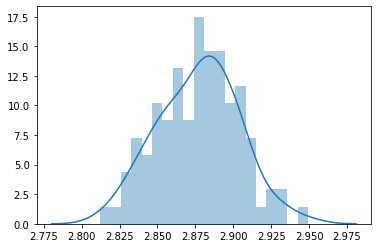

In [12]:
sns.distplot(scores, bins=20, norm_hist=True)

# Parameter search

We first perform a grid search to get a view of the landscape. Afterwards we use random search at a smaller range starting from the optimal point of the grid search.


In [13]:
# Grid search ranges

range_lambda = slice(5, 10, 1)
range_offset = (100, 300, 25)
range_window = slice(4900, 6000, 100)

In [14]:
x0_delay, fval, grid, j_out = opt.brute(func=simulate_and_score, ranges=(range_lambda, range_offset, range_window), 
                                        args=(score_2d, OPT_DURATION),
                                 workers=NUM_WORKERS, full_output=True, finish=None, disp=True)

Text(0.5, 0, 'Energy distance')

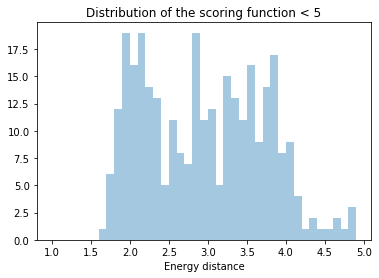

In [15]:
sns.distplot(j_out.flatten(), bins=np.arange(1, 5, 0.1), kde=False)
plt.title('Distribution of the scoring function < 5')
plt.xlabel('Energy distance')

In [16]:
offset = np.array([1.0, 25.0, 100.0])

In [17]:
# Random search range
vals = x0_delay.reshape(-1, 1) + (st.uniform.rvs(size=(3, 100)) - 0.5) * offset.reshape(-1, 1) * 2
num_params = vals.shape[1]

In [18]:
def _sim_pool(args):
  return simulate_and_score(args, score_2d, 300*1e9)

In [19]:
pool = mp.Pool(processes=NUM_WORKERS)


In [20]:
results = pool.map(_sim_pool, (v for v in vals.T)  )
pool.close()

In [21]:
min_res_index = np.argmin(np.array(results))
x0_delay_opt = vals.T[min_res_index]

min_res_index, x0_delay_opt

(34, array([   6.89521241,  195.41777643, 5146.75975594]))

In [22]:
SimArgs(*x0_delay_opt)._asdict()

OrderedDict([('num_reactions_mean', 6.895212410851494),
             ('burst_reaction_offset', 195.41777643172668),
             ('window_loc', 5146.759755942196)])

In [23]:
sim_df_fit = exchange.run_simulation(**SimArgs(*x0_delay_opt)._asdict(), duration=600*1e9, report_interval=30*1e9, reaction_time_mean=REACTION_TIME)

Success rate - simulation vs observed:
0.8026733500417711 0.7896463523131673
Energy distance:
1.594667253515032


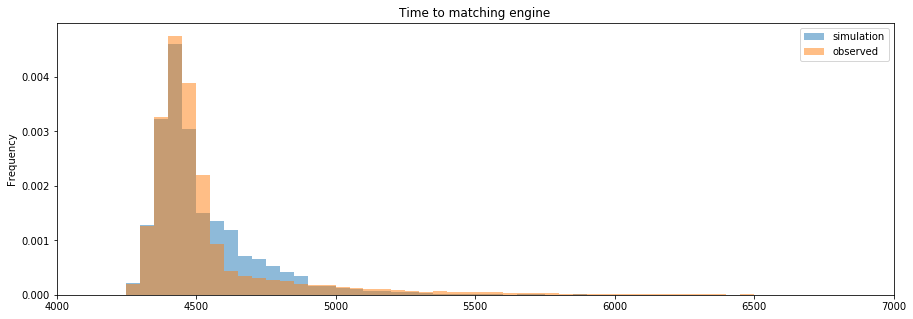

In [24]:
plt.figure(figsize=[15, 5])

sim_df_fit.time_to_me.plot(kind='hist', density=True, bins=np.arange(0, 8000, 50), alpha=.5, label='simulation')
df.time_to_me.plot(kind='hist', density=True, bins=np.arange(0, 8000, 50), alpha=.5, label='observed')

plt.legend()
plt.xlim([4000, 7000])
plt.title('Time to matching engine')

print ('Success rate - simulation vs observed:')
print(sim_df_fit.success.mean(), df.success.mean())

print ('Energy distance:')
print(st.energy_distance(sim_df_fit.time_to_me.sample(1000), df.time_to_me) )

# Predict changes

Now that we found the optimal parameters explaining the data, we want to see how the success rate changes if we vary the reaction time.

In [25]:
x0_delay_opt, x0_delay

(array([   6.89521241,  195.41777643, 5146.75975594]),
 array([   7.,  200., 5100.]))

In [26]:
def sim_parallel_success(reaction_time):
  print (f'{reaction_time}', end='\r')
  sim_df = exchange.run_simulation(duration=300*1e9, report_interval=100*1e9, reaction_time_mean=reaction_time, 
                                   **SimArgs(*x0_delay_opt)._asdict() )
  success_rate = sim_df.success.mean()
  return success_rate


reaction_range = np.arange(REACTION_TIME-400, REACTION_TIME+400, 5)

In [27]:
pool = mp.Pool(processes=NUM_WORKERS)
success_rates = list(pool.map(sim_parallel_success, reaction_range))
pool.close()

In [28]:
success_rates = np.array(success_rates)

In [29]:
from scipy.interpolate import interp1d

Text(0.5, 0, 'reaction_time')

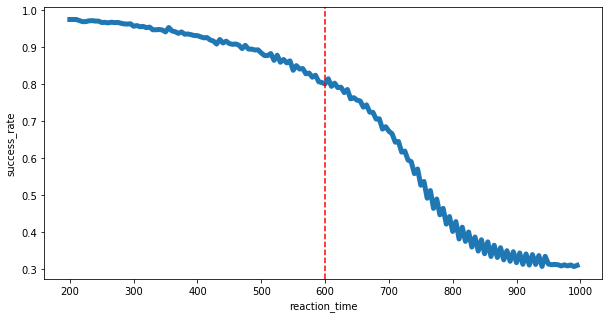

In [34]:
plt.figure(figsize=[10, 5])

sns.lineplot(x=reaction_range, y=success_rates, linewidth=5)
plt.axvline(x=REACTION_TIME, linestyle='--', color='r')

plt.ylabel('success_rate')
plt.xlabel('reaction_time')


In [32]:
def success_rate_for_time(r):
  argmin= np.argmin((reaction_range-r)**2)
  r_closest = reaction_range[argmin]
  s = success_rates[argmin]
  print((r,s))
  return r,s

In [33]:
print ('Success rate for reaction time = 700')
success_rate_for_time(700)
pass

Success rate for reaction time = 700
(700, 0.6732403944236655)
